In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from config import (
    DISTANCE,
    OUTPUT_DIRECTORY_RESULTS,
    get_results_filenames
)

RESULTS_CSV_NAME = get_results_filenames()[0]

FILENAME = RESULTS_CSV_NAME
OUTPUT = OUTPUT_DIRECTORY_RESULTS
os.makedirs(OUTPUT, exist_ok=True)

SAVE_PLOTS = True

In [2]:
def match_combo(row):
    if row["Filename_Match"] and row["Page_Match"]:
        return "File and Page"
    elif row["Filename_Match"]:
        return "Filename Only"
    elif row["Page_Match"]:
        return "Page Only"
    else:
        return "Neither"
    
matplotlib.rcParams['font.family'] = 'Segoe UI'  # or 'Roboto', 'Segoe UI'
PALETTE = "pastel"

In [3]:
def plot_stacked_matches_by_result(df):
    # Extract Result Number (e.g., R1, R2, ..., R5)
    df["Result_Num"] = df["Result_Id"].str.extract(r'(R[1-5])')

    # Create combined match string
    df["Match_Combo"] = df["Filename_Match"].astype(str) + "_File_" + df["Page_Match"].astype(str) + "_Page"

    # Create a count table: rows = Result_Num, columns = Match_Combo
    count_df = df.groupby(["Result_Num", "Match_Combo"]).size().unstack(fill_value=0)

    # Sort columns by total frequency
    desired_order = ['True_File_True_Page', 'True_File_False_Page', 'False_File_False_Page']
    count_df = count_df.reindex(columns=desired_order, fill_value=0)

    # Get pastel colors for the number of match combos
    match_combos = count_df.columns
    pastel_colors = sns.color_palette(PALETTE, n_colors=len(match_combos))

    # Set style
    sns.set_style("whitegrid")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    count_df.plot(kind="bar", stacked=True, ax=ax, color=pastel_colors)
    
    # Get total height per bar (to compute percentages)
    bar_totals = count_df.sum(axis=1)

    # Track number of segments and bars
    num_segments = len(count_df.columns)

    # Annotate each patch (segment of bar)
    for i, patch in enumerate(ax.patches):
        bar_idx = i // num_segments
        height = patch.get_height()
        total = bar_totals.iloc[bar_idx]
        
        if total > 0:
            percent = height / total * 100
            if percent >= 5:  # Optional: only show if >= 5%
                ax.annotate(
                    f"{percent:.1f}%",
                    (patch.get_x() + patch.get_width() / 2, patch.get_y() + height / 2),
                    ha='center',
                    va='center',
                    fontsize=9,
                    weight="bold",
                    color='black'
                )

    # Styling
    ax.set_title("Stacked Match Combinations by Result Number", fontsize=16, weight="bold")
    ax.set_xlabel("Result (R1-R5)", fontsize=12, labelpad=10, weight="bold")
    ax.set_ylabel("Count", fontsize=12, weight="bold")
    ax.set_xticks(range(len(count_df)))
    ax.set_xticklabels(count_df.index, fontsize=10)
    ax.tick_params(axis='y', labelsize=10)
    # ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    # ax.set_axisbelow(True)

    # Legend styling
    ax.legend(
        title="Match Combination",
        bbox_to_anchor=(1.02, 1),
        loc='upper left',
        borderaxespad=0,
        fontsize=9,
        title_fontsize=10
    )
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_stacked_matches_by_result.png", dpi=300, bbox_inches='tight')
    plt.show()

In [4]:
def plot_best_result_by_text_match(df):
    # Calculate combined score
    df["Combined_Score"] = df["Text_Match_Start_Percent"] + df["Text_Match_End_Percent"]
    df["Result_Tag"] = df["Result_Id"].str[-2:]
    df["Question_Id"] = df["Result_Id"].str[:-2]

    # Get best result per question
    best_results = df.loc[df.groupby("Question_Id")["Combined_Score"].idxmax()]

    # Count result tags (ensure all R1–R5 are present)
    result_order = ["R1", "R2", "R3", "R4", "R5"]
    counts = best_results["Result_Tag"].value_counts().reindex(result_order, fill_value=0)

    # Convert to percentage
    percentages = counts / counts.sum() * 100
    result_counts = percentages.reset_index()
    result_counts.columns = ["Result_Tag", "Percentage"]

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))

    ax = sns.barplot(
        data=result_counts,
        x="Result_Tag",
        y="Percentage",
        hue="Result_Tag",
        palette=PALETTE,
        legend=False
    )

    # Add percentage labels on top of bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 4),
            textcoords='offset points'
        )

    # Add top padding to y-axis
    top = ax.get_ylim()[1]
    ax.set_ylim(0, top * 1.1)

    # Styling
    plt.title("Best Result Based on Combined Text Match", fontsize=16, weight="bold")
    plt.xlabel("Result (R1-R5)", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage (%)", fontsize=12, weight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    # ax.set_axisbelow(True)
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_best_result_by_text_match.png", dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
def plot_filename_match_percentage_by_result(df):
    # Convert Filename_Match to boolean
    df["Filename_Match"] = df["Filename_Match"].astype(str) == "True"
    df["Result_Tag"] = df["Result_Id"].str[-2:]

    # Calculate percentage of matches for each result independently
    result_order = ["R1", "R2", "R3", "R4", "R5"]

    # Group by Result_Tag and calculate mean (since True=1, False=0)
    percentages = df.groupby("Result_Tag")["Filename_Match"].mean().reindex(result_order) * 100

    result_counts = percentages.reset_index()
    result_counts.columns = ["Result_Tag", "Percentage"]

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))

    ax = sns.barplot(
        data=result_counts,
        x="Result_Tag",
        hue="Result_Tag",
        y="Percentage",
        palette=PALETTE,
        legend=False
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 2),  # offset text a little above the bar
            textcoords='offset points'
        )

    # Styling
    plt.title("Filename_Match = True, Independent for each Result", fontsize=16, weight="bold")
    plt.xlabel("Result (R1-R5)", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage (%)", fontsize=12, weight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    # ax.set_axisbelow(True)

    top = ax.get_ylim()[1]  # current top y-limit
    ax.set_ylim(0, top * 1.1)  # increase top limit by 10%
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_filename_match_percentage_by_result.png", dpi=300, bbox_inches='tight')
    plt.show()

    # return result_counts


In [6]:
def plot_page_match_percentage_by_result(df):
    # Convert Page_Match to boolean
    df["Page_Match"] = df["Page_Match"].astype(str) == "True"
    df["Result_Tag"] = df["Result_Id"].str[-2:]

    # Calculate percentage of matches for each result independently
    result_order = ["R1", "R2", "R3", "R4", "R5"]

    # Group by Result_Tag and calculate mean (since True=1, False=0)
    percentages = df.groupby("Result_Tag")["Page_Match"].mean().reindex(result_order) * 100

    result_counts = percentages.reset_index()
    result_counts.columns = ["Result_Tag", "Percentage"]

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))

    ax = sns.barplot(
        data=result_counts,
        x="Result_Tag",
        hue="Result_Tag",
        y="Percentage",
        palette=PALETTE,
        legend=False
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 2),  # offset text a little above the bar
            textcoords='offset points'
        )

    # Styling
    plt.title("Page_Match = True, Independent for each Result", fontsize=16, weight="bold")
    plt.xlabel("Result (R1-R5)", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage (%)", fontsize=12, weight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    # ax.set_axisbelow(True)

    top = ax.get_ylim()[1]  # current top y-limit
    ax.set_ylim(0, top * 1.1)  # increase top limit by 10%
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_page_match_percentage_by_result.png", dpi=300, bbox_inches='tight')
    plt.show()

    # return result_counts


In [7]:
def plot_chunk_match_percentage_by_result(df):
    # Convert Match_Threshold to boolean
    df["Match_Threshold"] = df["Match_Threshold"].astype(str) == "True"
    df["Result_Tag"] = df["Result_Id"].str[-2:]

    # Calculate percentage of matches for each result independently
    result_order = ["R1", "R2", "R3", "R4", "R5"]

    # Group by Result_Tag and calculate mean (since True=1, False=0)
    percentages = df.groupby("Result_Tag")["Match_Threshold"].mean().reindex(result_order) * 100

    result_counts = percentages.reset_index()
    result_counts.columns = ["Result_Tag", "Percentage"]

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))

    ax = sns.barplot(
        data=result_counts,
        x="Result_Tag",
        hue="Result_Tag",
        y="Percentage",
        palette=PALETTE,
        legend=False
    )

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f'{height:.1f}%',
            (p.get_x() + p.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 2),  # offset text a little above the bar
            textcoords='offset points'
        )

    # Styling
    plt.title("Match_Threshold = True, Independent for each Result", fontsize=16, weight="bold")
    plt.xlabel("Result (R1-R5)", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage (%)", fontsize=12, weight="bold")
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    # ax.set_axisbelow(True)

    top = ax.get_ylim()[1]  # current top y-limit
    ax.set_ylim(0, top * 1.1)  # increase top limit by 10%
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_chunk_match_percentage_by_result.png", dpi=300, bbox_inches='tight')
    plt.show()

    # return result_counts


In [8]:
def plot_threshold_given_page_match(df):
    pastel_colors = sns.color_palette(PALETTE, n_colors=2)
    # Filter only where Page_Match is True
    filtered_df = df[df["Page_Match"]]

    # Get percentages for Match_Threshold
    threshold_percentages = (
        filtered_df["Match_Threshold"]
        .value_counts(normalize=True)
        .reindex([True, False], fill_value=0) * 100
    )

    # Plot setup
    sns.set_style("whitegrid")
    plt.figure(figsize=(6, 5))
    ax = plt.bar(
        threshold_percentages.index.map(str),
        threshold_percentages.values,
        color=pastel_colors
    )

    # Title and labels
    plt.title("Match Threshold (Where Page Match = True)", fontsize=14, weight="bold")
    plt.xlabel("Match_Threshold", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage", fontsize=12, weight="bold")

    # Annotate each bar
    for bar in ax:
        height = bar.get_height()
        plt.annotate(
            f"{height:.1f}%",
            (bar.get_x() + bar.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=10,
            weight="bold",
            xytext=(0, 3),
            textcoords="offset points"
        )

    plt.ylim(0, max(threshold_percentages.values) * 1.15)  # add headroom
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_threshold_given_page_match.png", dpi=300, bbox_inches='tight')
    plt.show()


In [9]:
def plot_guessed_file_occurrences(df):
    # Count and compute percentages
    file_counts = df["Guessed_File"].value_counts()
    file_percentages = file_counts / file_counts.sum() * 100
    file_percentages = file_percentages.sort_values(ascending=False)

    # Prepare positions with spacing
    labels = file_percentages.index.tolist()
    values = file_percentages.values
    x = np.arange(len(labels))
    bar_width = 0.9  # < 1.0 gives spacing between bars

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(35, 15))
    bars = plt.bar(x, values, width=bar_width, color=sns.color_palette(PALETTE, len(values)))

    # Annotations
    for i, bar in enumerate(bars):
        height = bar.get_height()
        plt.annotate(
            f"{height:.1f}%",
            (bar.get_x() + bar.get_width() / 2, height),
            ha="center",
            va="bottom",
            fontsize=9,
            weight="bold",
            xytext=(0, 2),
            textcoords="offset points"
        )

    # Axis and style
    plt.title("Distribution of Guessed Files", fontsize=14, weight="bold")
    plt.xlabel("Guessed File", fontsize=12, labelpad=10, weight="bold")
    plt.ylabel("Percentage", fontsize=12, weight="bold")
    plt.xticks(x, labels, rotation=30, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, max(values) * 1.15)
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    # if SAVE_PLOTS:
    #     plt.savefig(OUTPUT +"plot_guessed_file_occurrences.png", dpi=300, bbox_inches='tight')
    plt.show()

In [10]:
def plot_acc_by_cat(df):
    pastel_colors = sns.color_palette(PALETTE, n_colors=2)
    # Extract Query_ID and compute any match per query
    df['Query_ID'] = df['Result_Id'].str[:-2]
    query_match = df.groupby('Query_ID')['Match_Threshold'].any().reset_index(name='Any_Match')
    query_category = df.groupby('Query_ID')['Category'].first().reset_index()
    query_summary = pd.merge(query_match, query_category, on='Query_ID')

    # Count true/false per category
    df_counts = query_summary.groupby(['Category', 'Any_Match']).size().unstack(fill_value=0)

    # Calculate percentages
    df_percent = df_counts.div(df_counts.sum(axis=1), axis=0) * 100

    # Sort categories (optional: by match rate or alphabetically)
    df_percent = df_percent.sort_index()

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(16, 6))
    categories = df_percent.index
    true_vals = df_percent[True] if True in df_percent else [0]*len(categories)
    false_vals = df_percent[False] if False in df_percent else [0]*len(categories)

    bar1 = plt.bar(categories, false_vals, label='No Match', color=pastel_colors[1])
    bar2 = plt.bar(categories, true_vals, bottom=false_vals, label='Match', color=pastel_colors[0])

    # Annotate each segment with %
    for bars, values in zip([bar1, bar2], [false_vals, true_vals]):
        for bar, value in zip(bars, values):
            total_counts = df_counts.sum(axis=1)
            for idx, (cat, total) in enumerate(total_counts.items()):
                bar_height = false_vals.iloc[idx] + true_vals.iloc[idx]
                plt.text(
                    idx, 
                    bar_height + 2,  # slightly above the top
                    f"{int(total)}\nQueries", 
                    ha='center', 
                    va='bottom',
                    fontsize=9,
                    color='black',
                )
            if value > 4:  # Optional threshold to avoid clutter
                plt.annotate(
                    f"{value:.1f}%",
                    (bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2),
                    ha='center',
                    va='center',
                    fontsize=9,
                    # fontweight="bold",
                    color='black'
                )

    # Titles and axis
    plt.title("Match Threshold Accuracy by Category", fontsize=14, weight="bold")
    plt.ylabel("Percentage of Queries", fontsize=12, weight="bold")
    plt.xlabel("Category", fontsize=12, labelpad=10, weight="bold")
    plt.xticks(rotation=30, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.ylim(0, 135)  # extra space for annotations
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], title="Any Match Threshold Met")
    # plt.legend(title="Any Match Threshold Met")
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_acc_by_cat.png", dpi=300, bbox_inches='tight')
    plt.show()

In [11]:
def plot_accuracy_precision_recall(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]

    # Accuracy
    accuracy_df = df.groupby('Query_ID')['Filename_Match'].any()
    accuracy = accuracy_df.mean()

    # Filter by distance threshold
    filtered_df = df[df['Distance'] <= DISTANCE]

    # Precision
    matches_after_filter = filtered_df.groupby('Query_ID')['Filename_Match'].any()
    queries_with_results = filtered_df['Query_ID'].unique()
    precision = matches_after_filter.sum() / len(queries_with_results)

    # Recall
    all_queries = df['Query_ID'].unique()
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))

    # Log to file
    with open(OUTPUT + "APR_Files.txt", "w") as f:
        def log(message):
            print(message)
            f.write(message + "\n")

        log(f"Accuracy: {accuracy:.2f}")
        log(f"Precision: {precision:.2f}")
        log(f"Recall: {recall:.2f}")
        log("Queries with results after filtering: " + str(len(queries_with_results)))
        log("Queries with no results after filtering: " + str(len(queries_with_no_results)))
        log("Total number of queries: " + str(len(all_queries)))

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))
    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [accuracy * 100, precision * 100, recall * 100]  # convert to %
    colors = sns.color_palette(PALETTE, n_colors=3)

    bars = plt.bar(metrics, values, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{height:.1f}%",
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 5),
            textcoords='offset points'
        )

    plt.ylim(0, 110)
    plt.ylabel("Percentage", fontsize=12, weight="bold")
    plt.title("Evaluation Metrics (Files)", fontsize=14, weight="bold")
    plt.xticks(fontsize=11, weight="bold")
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_accuracy_precision_recall.png", dpi=300, bbox_inches='tight')
    plt.show()

In [12]:
def plot_accuracy_precision_recall_pages(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Page_Match'].any()
    accuracy = accuracy_df.mean()

    # Filter by Distance (Random chpice of 0.85, we should think abot this)
    filtered_df = df[df['Distance'] <= DISTANCE]

    # Precision calculation
    matches_after_filter = filtered_df.groupby('Query_ID')['Page_Match'].any()
    queries_with_results = filtered_df['Query_ID'].unique()
    precision = matches_after_filter.sum() / len(queries_with_results)
    
    # Recall calculation
    all_queries = df['Query_ID'].unique()
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))
    
    # Log to file
    with open(OUTPUT + "APR_Pages.txt", "w") as f:
        def log(message):
            print(message)
            f.write(message + "\n")

        log(f"Accuracy: {accuracy:.2f}")
        log(f"Precision: {precision:.2f}")
        log(f"Recall: {recall:.2f}")
        log("Queries with results after filtering: " + str(len(queries_with_results)))
        log("Queries with no results after filtering: " + str(len(queries_with_no_results)))
        log("Total number of queries: " + str(len(all_queries)))

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))
    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [accuracy * 100, precision * 100, recall * 100]  # convert to %
    colors = sns.color_palette(PALETTE, n_colors=3)

    bars = plt.bar(metrics, values, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{height:.1f}%",
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 5),
            textcoords='offset points'
        )

    plt.ylim(0, 110)
    plt.ylabel("Percentage", fontsize=12, weight="bold")
    plt.title("Evaluation Metrics (Pages)", fontsize=14, weight="bold")
    plt.xticks(fontsize=11, weight="bold")
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_accuracy_precision_recall_pages.png", dpi=300, bbox_inches='tight')
    plt.show()

In [13]:
def plot_accuracy_precision_recall_chunks(df):
    df['Query_ID'] = df['Result_Id'].str[:-2]
    
    # Compute Accuracy (regardless of Distance)
    accuracy_df = df.groupby('Query_ID')['Match_Threshold'].any()
    accuracy = accuracy_df.mean()

    # Filter by Distance (Random chpice of 0.85, we should think abot this)
    filtered_df = df[df['Distance'] <= DISTANCE]

    # Precision calculation
    matches_after_filter = filtered_df.groupby('Query_ID')['Match_Threshold'].any()
    queries_with_results = filtered_df['Query_ID'].unique()
    precision = matches_after_filter.sum() / len(queries_with_results)

    # Recall calculation
    all_queries = df['Query_ID'].unique()
    queries_with_no_results = set(all_queries) - set(queries_with_results)
    recall = matches_after_filter.sum() / (matches_after_filter.sum() + len(queries_with_no_results))
    
    # Log to file
    with open(OUTPUT + "APR_Chunks.txt", "w") as f:
        def log(message):
            print(message)
            f.write(message + "\n")

        log(f"Accuracy: {accuracy:.2f}")
        log(f"Precision: {precision:.2f}")
        log(f"Recall: {recall:.2f}")
        log("Queries with results after filtering: " + str(len(queries_with_results)))
        log("Queries with no results after filtering: " + str(len(queries_with_no_results)))
        log("Total number of queries: " + str(len(all_queries)))

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(7, 5))
    metrics = ['Accuracy', 'Precision', 'Recall']
    values = [accuracy * 100, precision * 100, recall * 100]  # convert to %
    colors = sns.color_palette(PALETTE, n_colors=3)

    bars = plt.bar(metrics, values, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(
            f"{height:.1f}%",
            (bar.get_x() + bar.get_width() / 2, height),
            ha='center',
            va='bottom',
            fontsize=10,
            weight="bold",
            xytext=(0, 5),
            textcoords='offset points'
        )

    plt.ylim(0, 110)
    plt.ylabel("Percentage", fontsize=12, weight="bold")
    plt.title("Evaluation Metrics (Chunks, Match_Thershold)", fontsize=14, weight="bold")
    plt.xticks(fontsize=11, weight="bold")
    plt.yticks(fontsize=10)
    plt.grid(axis='both', linestyle='--', alpha=0.3)
    plt.tight_layout()
    if SAVE_PLOTS:
        plt.savefig(OUTPUT +"plot_accuracy_precision_recall_chunks.png", dpi=300, bbox_inches='tight')
    plt.show()

Accuracy: 0.96
Precision: 0.93
Recall: 0.97
Queries with results after filtering: 204
Queries with no results after filtering: 5
Total number of queries: 209


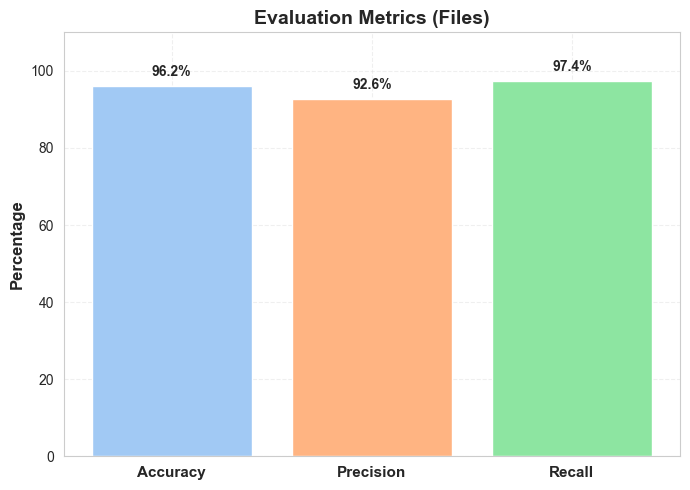

Accuracy: 0.96
Precision: 0.93
Recall: 0.97
Queries with results after filtering: 204
Queries with no results after filtering: 5
Total number of queries: 209


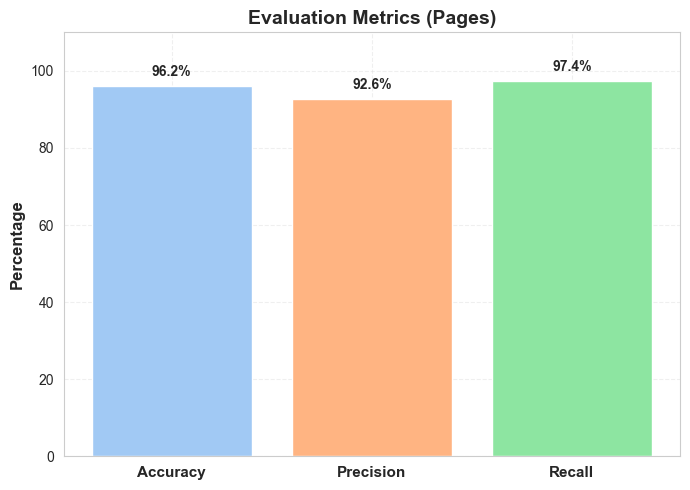

Accuracy: 0.80
Precision: 0.75
Recall: 0.97
Queries with results after filtering: 204
Queries with no results after filtering: 5
Total number of queries: 209


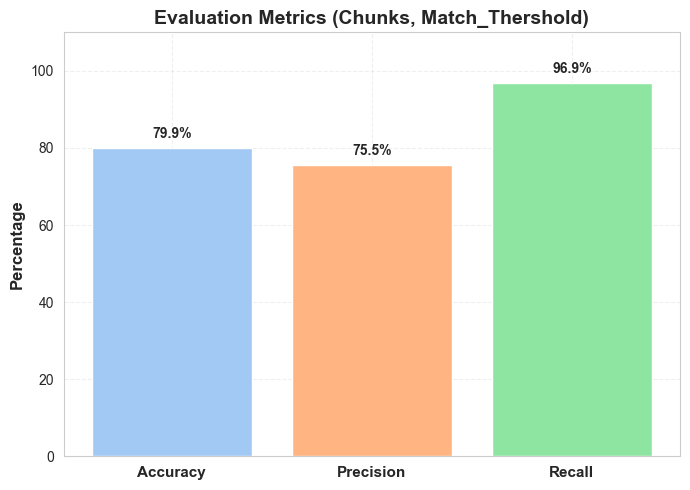

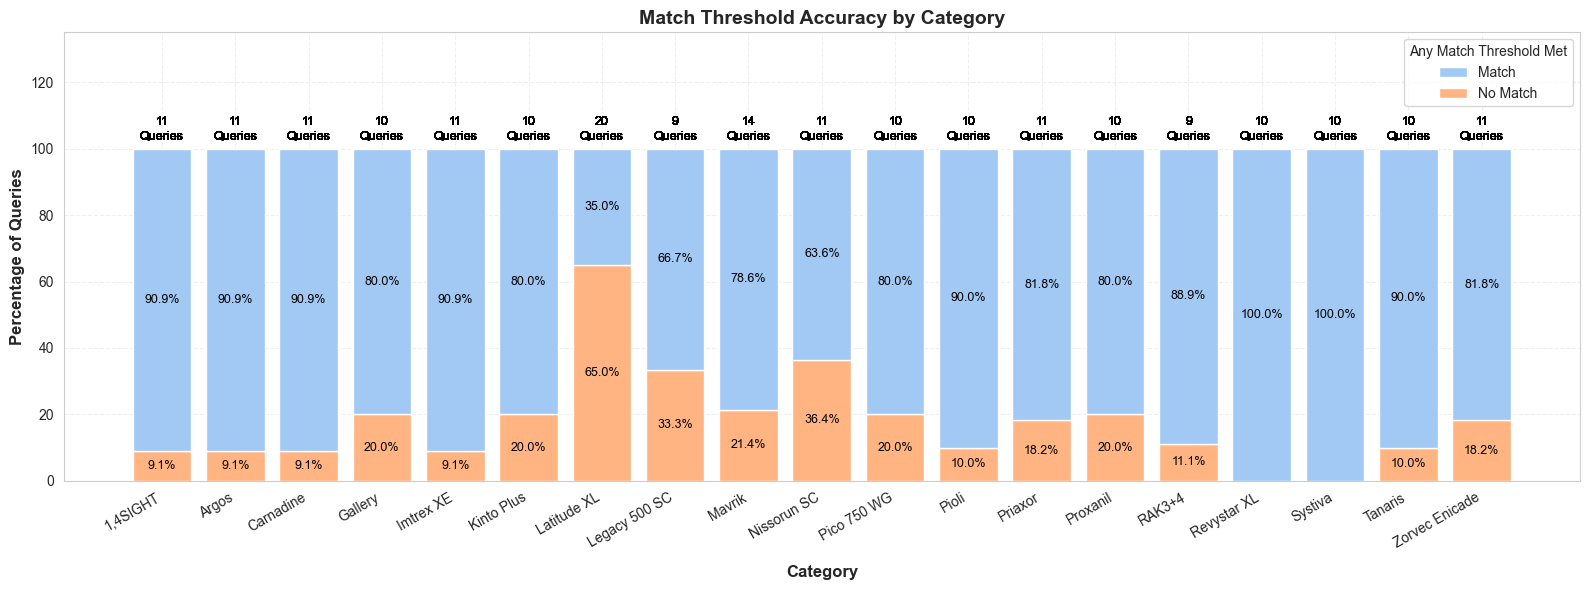

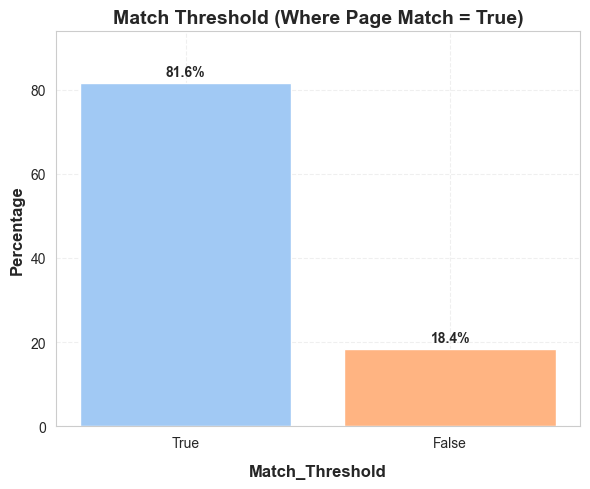

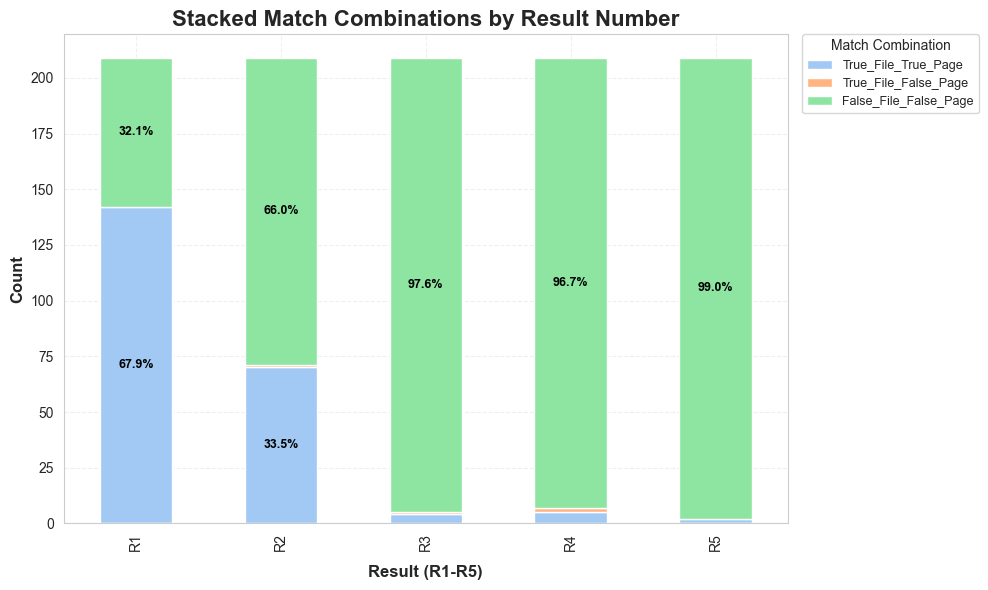

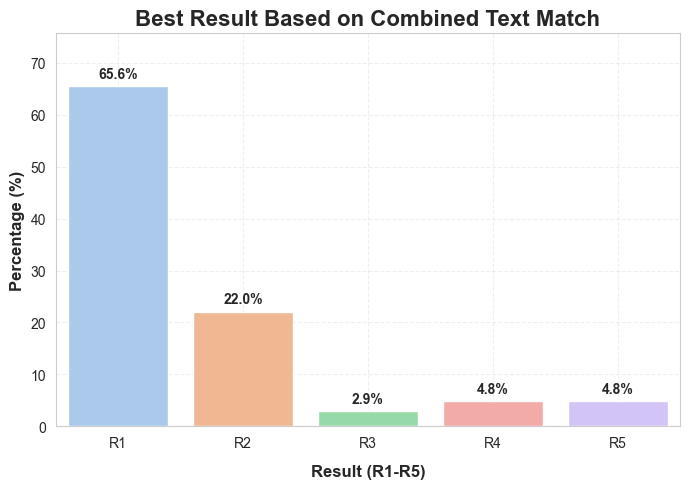

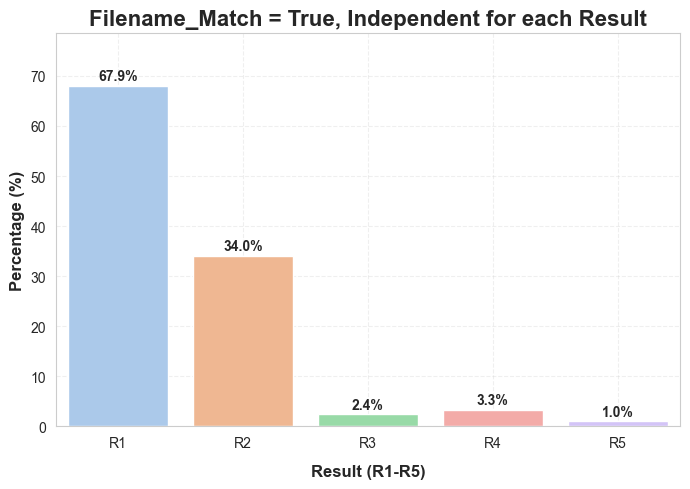

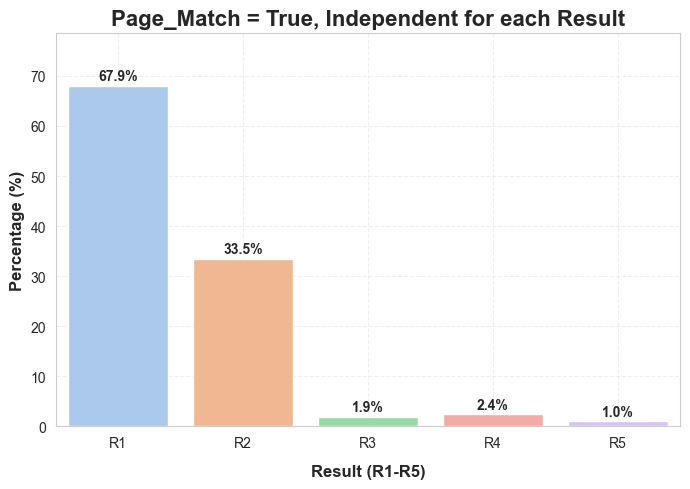

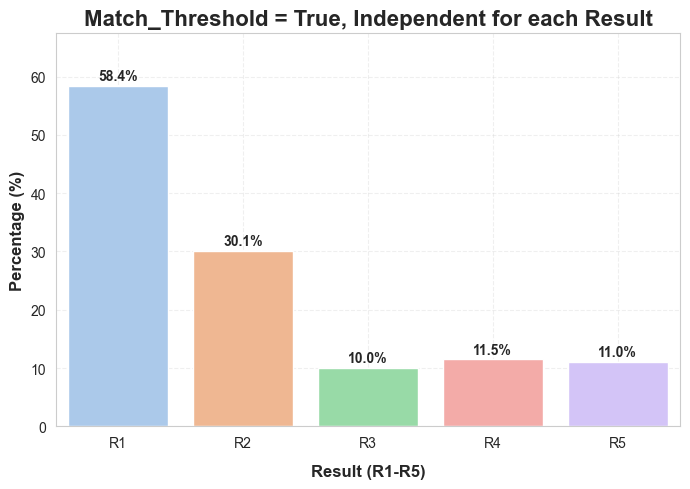

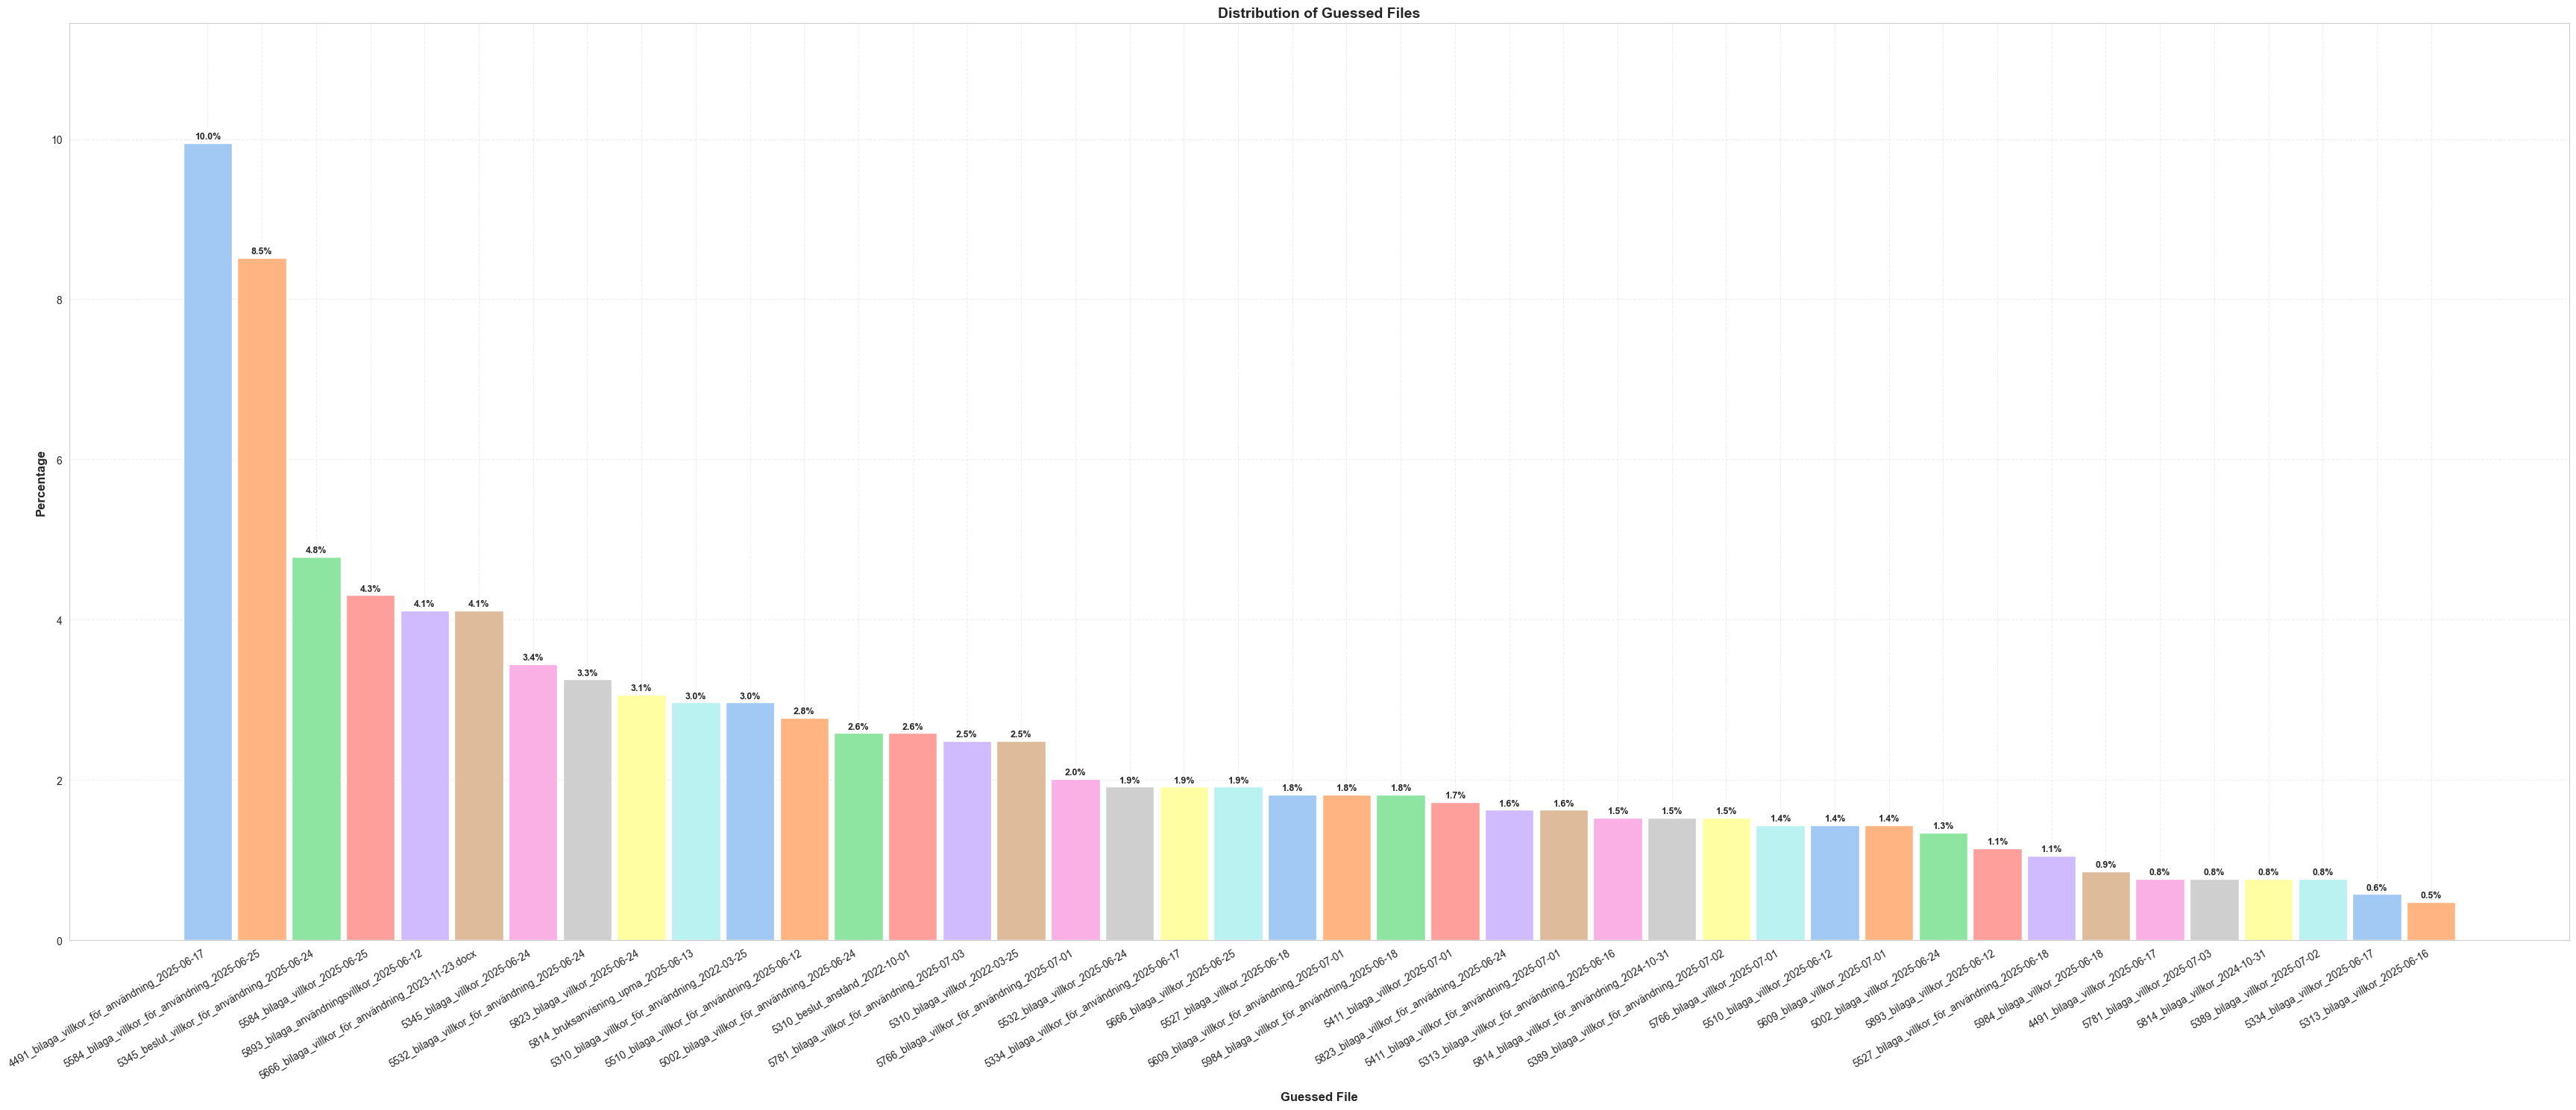

In [14]:
df = pd.read_csv(FILENAME, sep=",", encoding="utf-8")
plot_accuracy_precision_recall(df)
plot_accuracy_precision_recall_pages(df)
plot_accuracy_precision_recall_chunks(df)
plot_acc_by_cat(df)
plot_threshold_given_page_match(df)
plot_stacked_matches_by_result(df)
plot_best_result_by_text_match(df)
plot_filename_match_percentage_by_result(df)
plot_page_match_percentage_by_result(df)
plot_chunk_match_percentage_by_result(df)
plot_guessed_file_occurrences(df)
